# Описание проекта

Из банка стали уходить клиенты, каждый месяц. Банковские маркетологи посчитали: сохранять текущих клиентов дешевле, чем привлекать новых.
Нужно спрогнозировать, уйдёт клиент из банка в ближайшее время или нет. Предоставлены исторические данные о поведении клиентов и расторжении договоров с банком.  

**Цель:** Постройть модель с предельно большим значением F1-меры. Проверить F1-меру на тестовой выборке.
Измерить AUC-ROC, сравнить её значение с F1-мерой.

**Признаки**
* `RowNumber` — индекс строки в данных
* `CustomerId` — уникальный идентификатор клиента
* `Surname` — фамилия
* `CreditScore` — кредитный рейтинг
* `Geography` — страна проживания
* `Gender` — пол
* `Age` — возраст
* `Tenure` — сколько лет человек является клиентом банка
* `Balance` — баланс на счёте
* `NumOfProducts` — количество продуктов банка, используемых клиентом
* `HasCrCard` — наличие кредитной карты
* `IsActiveMember` — активность клиента
* `EstimatedSalary` — предполагаемая зарплата

**Целевой признак**
* `Exited` — факт ухода клиента

# Изучение данных

In [1]:
import pandas as pd
import random
import seaborn as sns

import matplotlib.pyplot as plt

import sklearn
from sklearn.metrics import *

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.utils import shuffle
from sklearn.preprocessing import OrdinalEncoder, StandardScaler
from pandas.plotting import scatter_matrix

from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier

In [ ]:
try:
  !gdown --id 1hPT3YB6mqzkn76P6GDfF2kTvGGGkeaZT --quiet
  data = pd.read_csv('Churn.csv')
except:
  data = pd.read_csv('/datasets/Churn.csv')

/usr/local/lib/python3.8/dist-packages/gdown/cli.py:127: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  warnings.warn(
Downloading...
From: https://drive.google.com/uc?id=1hPT3YB6mqzkn76P6GDfF2kTvGGGkeaZT
To: /content/Churn.csv
100% 710k/710k [00:00<00:00, 91.1MB/s]


In [ ]:
data.head()

,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,1,15634602,Hargrave,619,France,Female,42,2.0,0.00,1,1,1,101348.88,1
1,2,15647311,Hill,608,Spain,Female,41,1.0,83807.86,1,0,1,112542.58,0
2,3,15619304,Onio,502,France,Female,42,8.0,159660.80,3,1,0,113931.57,1
3,4,15701354,Boni,699,France,Female,39,1.0,0.00,2,0,0,93826.63,0
4,5,15737888,Mitchell,850,Spain,Female,43,2.0,125510.82,1,1,1,79084.10,0


In [ ]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 14 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   RowNumber        10000 non-null  int64  
 1   CustomerId       10000 non-null  int64  
 2   Surname          10000 non-null  object 
 3   CreditScore      10000 non-null  int64  
 4   Geography        10000 non-null  object 
 5   Gender           10000 non-null  object 
 6   Age              10000 non-null  int64  
 7   Tenure           9091 non-null   float64
 8   Balance          10000 non-null  float64
 9   NumOfProducts    10000 non-null  int64  
 10  HasCrCard        10000 non-null  int64  
 11  IsActiveMember   10000 non-null  int64  
 12  EstimatedSalary  10000 non-null  float64
 13  Exited           10000 non-null  int64  
dtypes: float64(3), int64(8), object(3)
memory usage: 1.1+ MB


In [ ]:
print(f'Количество явных дубликатов {data.duplicated().sum()}')

Количество явных дубликатов 0


In [ ]:
data['Exited'].value_counts(normalize=True)

0    0.7963
1    0.2037
Name: Exited, dtype: float64

**Итак,** в таблице 10 000 строк, 14 столбцов. Пропуски есть только в колонке `Tenure`(909 шт.) - сколько лет человек является клиентом банка. Возможно эти пропуски возникли случайно при сборе данных или заполнении. Явных дубликатов нет. В основным признаки представлены числами(данные есть и количественные и категориальные), тип object у колонок с фамилией, страной проживания и полом. Наблюдается дисбаланс классов, нулей почти в 4 раза больше, чем класса единиц.

Для удобства переведем названия колонок в нижний регистор.

In [ ]:
data.columns = data.columns.str.replace(r"([A-Z])", r" \1").str.lower().str.replace(' ', '_').str[1:]

<ipython-input-218-19857ba1cf44>:1: FutureWarning: The default value of regex will change from True to False in a future version.
  data.columns = data.columns.str.replace(r"([A-Z])", r" \1").str.lower().str.replace(' ', '_').str[1:]


In [ ]:
data.columns

Index(['row_number', 'customer_id', 'surname', 'credit_score', 'geography',
       'gender', 'age', 'tenure', 'balance', 'num_of_products', 'has_cr_card',
       'is_active_member', 'estimated_salary', 'exited'],
      dtype='object')

### Подготовка данных

Для нашей модели нужны не все колонки. Например, данные в колонках `RowNumber`, `CustomerId`, `Surname` не влияют на уход клиента, это просто информация о нем, то есть номер колонки, уникальный id и фамилия. Удалим эти колонки.

In [ ]:
df = data.drop(['row_number', 'customer_id', 'surname'], axis=1)
df.head()

,credit_score,geography,gender,age,tenure,balance,num_of_products,has_cr_card,is_active_member,estimated_salary,exited
0,619,France,Female,42,2.0,0.00,1,1,1,101348.88,1
1,608,Spain,Female,41,1.0,83807.86,1,0,1,112542.58,0
2,502,France,Female,42,8.0,159660.80,3,1,0,113931.57,1
3,699,France,Female,39,1.0,0.00,2,0,0,93826.63,0
4,850,Spain,Female,43,2.0,125510.82,1,1,1,79084.10,0


Посмотрим на коэффициент корреляции наших данных.

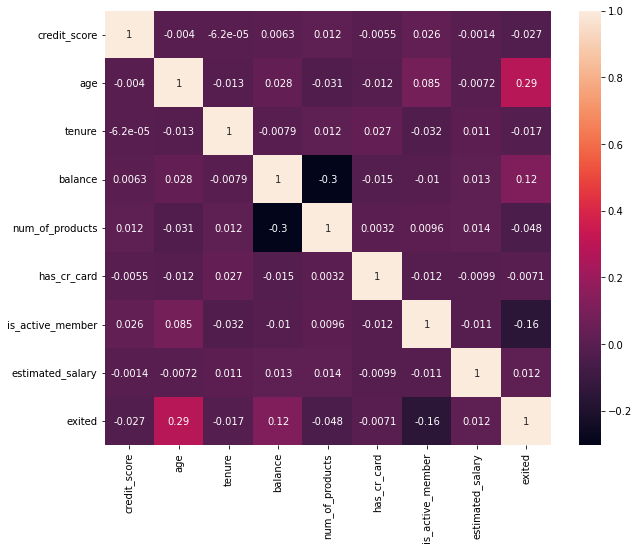

In [ ]:
plt.figure(figsize=(10,8))
sns.heatmap(df.corr(), annot=True)


Видим, что колонка `tenure` практически не коррелирует с другими колонками. Заметна прямая зависимость между возрастом и уходом из банка. Также есть обратная зависимость между количеством продуктов в банке и балансом. Остальные коэффициенты близки к нулю.

Надо заменить пропуски в колонке `tenure`. 

In [ ]:
df['tenure'].isna().sum()

909

Заменим пропуски на значение -1.

In [ ]:
df['tenure'].fillna(-1, inplace =True)

In [ ]:
df['tenure'].unique()

array([ 2.,  1.,  8.,  7.,  4.,  6.,  3., 10.,  5.,  9.,  0., -1.])

Напишем функцию для замены значений на случайное число и применим ее к столбцу.

In [ ]:
df['tenure'].value_counts()

 1.0     952
 2.0     950
 8.0     933
 3.0     928
 5.0     927
 7.0     925
-1.0     909
 4.0     885
 9.0     882
 6.0     881
 10.0    446
 0.0     382
Name: tenure, dtype: int64

In [ ]:
def nul(row):
  if row == -1:
    row = random.randint(0, 10)
  return row

In [ ]:
df['tenure'] = df['tenure'].apply(nul)

In [ ]:
df['tenure'].unique()


array([ 2.,  1.,  8.,  7.,  4.,  6.,  3., 10.,  5.,  9.,  0.])

In [ ]:
df['tenure'].value_counts()

1.0     1031
3.0     1025
2.0     1022
8.0     1017
5.0     1007
7.0     1006
6.0      969
4.0      962
9.0      948
10.0     538
0.0      475
Name: tenure, dtype: int64

# Обучение без учета дисбаланса

## Логистическая регрессия

### Разделим данные

Разделим данные на признаки и целевой показатель.

In [ ]:
features_ohe = df.drop(['exited'], axis=1)
target_ohe = df['exited']

Разделим в отношении 3:1:1.

In [ ]:
features_train_ohe, features_test_ohe, target_train_ohe, target_test_ohe \
= train_test_split(features_ohe, target_ohe, test_size=0.4, random_state=12345, stratify=target_ohe)

In [ ]:
features_valid_ohe, features_test_ohe, target_valid_ohe, target_test_ohe \
= train_test_split(features_test_ohe, target_test_ohe, test_size=0.5, random_state=12345, stratify=target_test_ohe)

In [ ]:
print(f'Обучающая: {features_train_ohe.shape}, Валидационная: {features_valid_ohe.shape}, Тестовая: {features_test_ohe.shape}')

Обучающая: (6000, 10), Валидационная: (2000, 10), Тестовая: (2000, 10)


Посмотрим на соотношение классов в наших выборках(для сохранения отношения классов использовали `stratify`)

In [ ]:
target_train_ohe.value_counts(normalize=True)

0    0.796333
1    0.203667
Name: exited, dtype: float64

In [ ]:
target_test_ohe.value_counts(normalize=True)

0    0.7965
1    0.2035
Name: exited, dtype: float64

### Преобразуем категориальные признаки в численные

Для логистической регрессии будем использовать метод OHE(Порядковое кодирование не подойдет для этой модели, потому как она может решить, что критерий с значением 3 важнее чем критерий с значением 1). Для избежания дамми-ловушки удалим один из преобразованных столбцов.

In [ ]:
df['geography'].unique(), df['gender'].unique()

(array(['France', 'Spain', 'Germany'], dtype=object),
 array(['Female', 'Male'], dtype=object))

In [ ]:
features_train_ohe = pd.get_dummies(features_train_ohe, columns=['geography', 'gender'], drop_first=True)
features_train_ohe.head()

,credit_score,age,tenure,balance,num_of_products,has_cr_card,is_active_member,estimated_salary,geography_Germany,geography_Spain,gender_Male
2837,549,49,6.0,124829.16,1,0,1,93551.36,1,0,0
9925,694,38,0.0,195926.39,1,1,1,85522.84,0,0,0
8746,660,34,8.0,106486.66,2,0,1,182262.66,0,0,1
660,632,41,6.0,81877.38,1,1,1,33642.21,1,0,0
3610,580,56,1.0,131368.30,1,1,0,106918.67,0,0,0


In [ ]:
features_valid_ohe = pd.get_dummies(features_valid_ohe, columns=['geography', 'gender'], drop_first=True)
features_valid_ohe.head()

,credit_score,age,tenure,balance,num_of_products,has_cr_card,is_active_member,estimated_salary,geography_Germany,geography_Spain,gender_Male
6612,502,64,3.0,139663.37,1,0,1,100995.11,0,0,0
519,707,58,6.0,89685.92,1,0,1,126471.13,0,0,1
1609,619,35,8.0,132292.63,1,1,0,65682.93,0,0,0
3475,769,31,4.0,61297.05,2,1,1,7118.02,0,0,1
2707,637,38,3.0,104339.56,1,0,0,119882.86,0,0,0


In [ ]:
features_test_ohe = pd.get_dummies(features_test_ohe, columns=['geography', 'gender'], drop_first=True)
features_test_ohe.head()

,credit_score,age,tenure,balance,num_of_products,has_cr_card,is_active_member,estimated_salary,geography_Germany,geography_Spain,gender_Male
657,601,54,1.0,131039.97,2,1,1,199661.50,1,0,0
2083,534,24,1.0,0.00,1,1,1,169653.32,0,0,1
3234,527,47,1.0,0.00,1,1,0,21312.16,0,0,1
1551,730,52,7.0,0.00,2,0,1,122398.84,0,1,0
2344,714,49,4.0,93059.34,1,1,0,7571.51,1,0,0


### Масштабируем данные

Посмотрим в каких числовых диапазонах находятся наши данные.

In [ ]:
df.describe()

,credit_score,age,tenure,balance,num_of_products,has_cr_card,is_active_member,estimated_salary,exited
count,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.00000,10000.000000,10000.000000,10000.000000
mean,650.528800,38.921800,4.993700,76485.889288,1.530200,0.70550,0.515100,100090.239881,0.203700
std,96.653299,10.487806,2.922382,62397.405202,0.581654,0.45584,0.499797,57510.492818,0.402769
min,350.000000,18.000000,0.000000,0.000000,1.000000,0.00000,0.000000,11.580000,0.000000
25%,584.000000,32.000000,2.000000,0.000000,1.000000,0.00000,0.000000,51002.110000,0.000000
50%,652.000000,37.000000,5.000000,97198.540000,1.000000,1.00000,1.000000,100193.915000,0.000000
75%,718.000000,44.000000,8.000000,127644.240000,2.000000,1.00000,1.000000,149388.247500,0.000000
max,850.000000,92.000000,10.000000,250898.090000,4.000000,1.00000,1.000000,199992.480000,1.000000


Выберем колонки для масштабирования.

In [ ]:
numeric = ['credit_score', 'age', 'tenure', 'balance', 'num_of_products', 'estimated_salary'] 

Настроим преобразователь на обучающей выборке. Затем преобразуем наши выборки.

In [ ]:
scaler = StandardScaler()
scaler.fit(features_train_ohe[numeric])
features_train_ohe[numeric] = scaler.transform(features_train_ohe[numeric])
features_valid_ohe[numeric] = scaler.transform(features_valid_ohe[numeric])
features_test_ohe[numeric] = scaler.transform(features_test_ohe[numeric])

In [ ]:
features_train_ohe.head()

,credit_score,age,tenure,balance,num_of_products,has_cr_card,is_active_member,estimated_salary,geography_Germany,geography_Spain,gender_Male
2837,-1.040434,0.953312,0.340643,0.774657,-0.914708,0,1,-0.119110,1,0,0
9925,0.454006,-0.095244,-1.712798,1.910540,-0.914708,1,1,-0.258658,0,0,0
8746,0.103585,-0.476537,1.025123,0.481608,0.820981,0,1,1.422836,0,0,1
660,-0.184996,0.190726,0.340643,0.088439,-0.914708,1,1,-1.160427,1,0,0
3610,-0.720933,1.620574,-1.370558,0.879129,-0.914708,1,0,0.113236,0,0,0


### Построим модель

In [ ]:
clf = LogisticRegression(random_state=12345, solver='liblinear')
clf.fit(features_train_ohe, target_train_ohe) # обучим модель
clf_predict = clf.predict(features_valid_ohe) # сохраним предсказания
confusion_matrix(target_valid_ohe, clf_predict) # построим матрицу ошибок

array([[1537,   55],
       [ 321,   87]])

Видим, что наша модель определила верно 1538 истинно положительных и 84 истинно отрицательных значений. Ложноно положительных 54, ложно отрицательных 324.

Посчитаем коэффициент детерминации. Он вычисляет долю средней квадратической ошибки модели от mse среднего, затем вычитает эту величину из единицы(то есть это показатель того, на сколько лучше чем среднее предсказывает наша модель).

In [ ]:
r2_score(target_valid_ohe, clf_predict)

-0.15774953197359332

Значение r2 отрицательное, качество модели низкое.

Построим кривую Precision-Recall.

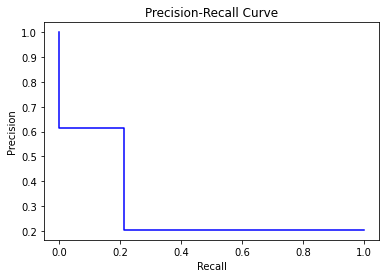

In [ ]:
# посчитаем precision и recall
precision, recall, thresholds = precision_recall_curve(target_valid_ohe, clf.predict(features_valid_ohe))

#создадим кривую precision recall
plt.step(recall, precision, where='post', color='blue')

#добавим подписи
plt.title('Precision-Recall Curve')
plt.ylabel('Precision')
plt.xlabel('Recall')

plt.show() 

Напишем функцию для нахождения F1 и построим ROC кривую.

In [ ]:
def metrics(target, features, model):
  fpr, tpr, treshold = roc_curve(target, model.predict_proba(features)[:,1])
  roc_auc = auc(fpr, tpr)
  # строим график
  plt.plot(fpr, tpr, color='darkorange',
         label='ROC кривая (area = %0.2f)' % roc_auc)
  plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
  plt.xlim([0.0, 1.0])
  plt.ylim([0.0, 1.05])
  plt.xlabel('False Positive Rate')
  plt.ylabel('True Positive Rate')
  plt.title('ROC-кривая')
  plt.legend(loc="lower right")
  plt.show()
  print('Показатели на тестовой выборке')
  print(f'F1 = {f1_score(target, model.predict(features))}')
  print(f'roc_auc = {roc_auc_score(target, model.predict_proba(features)[:,1])}')

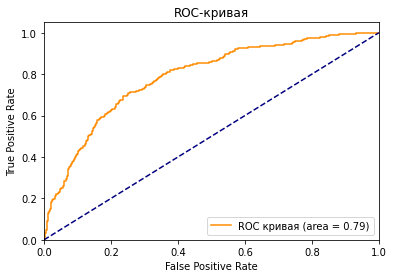

Показатели на тестовой выборке
F1 = 0.31636363636363635
roc_auc = 0.7872127180017735


In [ ]:
metrics(target_valid_ohe, features_valid_ohe, clf)

**Итак,** получили низкое качество модели. Значение F1 = 0.31, значение roc_auc = 0.78. Считаем, что если значение roc- кривой больше 0.5, то модель хорошая, но вот значение метрики F1 низкое.

## Дерево решений

### Разделим данные

In [ ]:
features = df.drop(['exited'], axis=1)
target = df['exited']

In [ ]:
features_train_ord, features_test_ord, target_train_ord, target_test_ord \
= train_test_split(features, target, test_size=0.4, random_state=12345, stratify=target)
features_valid_ord, features_test_ord, target_valid_ord, target_test_ord \
= train_test_split(features_test_ord, target_test_ord, test_size=0.5, random_state=12345, stratify=target_test_ord)

In [ ]:
print(f'Обучающая: {features_train_ord.shape}, Валидационная: {features_valid_ord.shape}, Тестовая: {features_test_ord.shape}')


Обучающая: (6000, 10), Валидационная: (2000, 10), Тестовая: (2000, 10)


### Преобразуем категориальные признаки в численные

Для моделей с деревьями использовать метод OHE нежелательно. Дерево, с таким методом растет в одну сторону, так же оно вряд ли возьмет фиктивную переменную для прикорневого разделения(то есть уменьшит важность признака, хотя это может быть не так). Поэтому для случайного леса и дерева решений возьмем метод порядкового кодирования Ordinal Encoding.

In [ ]:
encoder = OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1)

In [ ]:
features_train_ord.head()

,credit_score,geography,gender,age,tenure,balance,num_of_products,has_cr_card,is_active_member,estimated_salary
2837,549,Germany,Female,49,6.0,124829.16,1,0,1,93551.36
9925,694,France,Female,38,0.0,195926.39,1,1,1,85522.84
8746,660,France,Male,34,8.0,106486.66,2,0,1,182262.66
660,632,Germany,Female,41,6.0,81877.38,1,1,1,33642.21
3610,580,France,Female,56,1.0,131368.30,1,1,0,106918.67


In [ ]:
encoder.fit(features_train_ord[['geography', 'gender']])
features_train_ord[['geography', 'gender']] = encoder.transform(features_train_ord[['geography', 'gender']])

features_train_ord.head()

,credit_score,geography,gender,age,tenure,balance,num_of_products,has_cr_card,is_active_member,estimated_salary
2837,549,1.0,0.0,49,6.0,124829.16,1,0,1,93551.36
9925,694,0.0,0.0,38,0.0,195926.39,1,1,1,85522.84
8746,660,0.0,1.0,34,8.0,106486.66,2,0,1,182262.66
660,632,1.0,0.0,41,6.0,81877.38,1,1,1,33642.21
3610,580,0.0,0.0,56,1.0,131368.30,1,1,0,106918.67


In [ ]:
features_valid_ord.tail()

,credit_score,geography,gender,age,tenure,balance,num_of_products,has_cr_card,is_active_member,estimated_salary
3063,609,France,Male,32,7.0,71872.19,1,1,1,151924.90
5951,721,France,Male,41,7.0,0.00,2,0,1,61018.85
9702,644,Spain,Female,31,5.0,86006.30,1,1,1,73922.95
7518,500,Germany,Male,30,2.0,125495.64,2,1,1,68807.47
828,630,Germany,Female,31,3.0,112373.49,2,1,1,131167.98


In [ ]:
features_valid_ord[['geography', 'gender']] = encoder.transform(features_valid_ord[['geography', 'gender']])

features_valid_ord.tail()

,credit_score,geography,gender,age,tenure,balance,num_of_products,has_cr_card,is_active_member,estimated_salary
3063,609,0.0,1.0,32,7.0,71872.19,1,1,1,151924.90
5951,721,0.0,1.0,41,7.0,0.00,2,0,1,61018.85
9702,644,2.0,0.0,31,5.0,86006.30,1,1,1,73922.95
7518,500,1.0,1.0,30,2.0,125495.64,2,1,1,68807.47
828,630,1.0,0.0,31,3.0,112373.49,2,1,1,131167.98


In [ ]:
features_test_ord.tail()

,credit_score,geography,gender,age,tenure,balance,num_of_products,has_cr_card,is_active_member,estimated_salary
5331,637,Germany,Female,46,2.0,143500.82,1,1,0,166996.46
4353,805,France,Female,31,4.0,0.00,2,1,0,4798.12
5876,704,France,Male,39,2.0,111525.02,1,1,0,199484.96
34,722,Spain,Female,29,9.0,0.00,2,1,1,142033.07
8832,753,France,Male,35,4.0,0.00,2,1,1,106303.40


In [ ]:
features_test_ord[['geography', 'gender']] = encoder.transform(features_test_ord[['geography', 'gender']])

features_test_ord.tail()

,credit_score,geography,gender,age,tenure,balance,num_of_products,has_cr_card,is_active_member,estimated_salary
5331,637,1.0,0.0,46,2.0,143500.82,1,1,0,166996.46
4353,805,0.0,0.0,31,4.0,0.00,2,1,0,4798.12
5876,704,0.0,1.0,39,2.0,111525.02,1,1,0,199484.96
34,722,2.0,0.0,29,9.0,0.00,2,1,1,142033.07
8832,753,0.0,1.0,35,4.0,0.00,2,1,1,106303.40


### Масштабируем данные

In [ ]:
scaler = StandardScaler()
scaler.fit(features_train_ord[numeric])
features_train_ord[numeric] = scaler.transform(features_train_ord[numeric])
features_valid_ord[numeric] = scaler.transform(features_valid_ord[numeric])
features_test_ord[numeric] = scaler.transform(features_test_ord[numeric])

In [ ]:
features_valid_ord

,credit_score,geography,gender,age,tenure,balance,num_of_products,has_cr_card,is_active_member,estimated_salary
6612,-1.524838,0.0,0.0,2.383160,-0.686077,1.011655,-0.914708,0,1,0.010275
519,0.587990,0.0,1.0,1.811221,0.340643,0.213192,-0.914708,0,1,0.453089
1609,-0.318980,0.0,0.0,-0.381213,1.025123,0.893896,-0.914708,1,0,-0.603508
3475,1.226991,0.0,1.0,-0.762506,-0.343837,-0.240363,0.820981,1,1,-1.621460
2707,-0.133464,0.0,0.0,-0.095244,-0.686077,0.447305,-0.914708,0,0,0.338574
...,...,...,...,...,...,...,...,...,...,...
3063,-0.422045,0.0,1.0,-0.667183,0.682883,-0.071409,-0.914708,1,1,0.895516
5951,0.732280,0.0,1.0,0.190726,0.682883,-1.219673,0.820981,0,1,-0.684577
9702,-0.061318,2.0,0.0,-0.762506,-0.001597,0.154404,-0.914708,1,1,-0.460283
7518,-1.545451,1.0,1.0,-0.857830,-1.028318,0.785305,0.820981,1,1,-0.549198


### Построим модель

In [ ]:
model__tree = None # будет здесь лучшая модель дерева
best_result = 0

for depth in range(1, 10):
  model = DecisionTreeClassifier(random_state=12345, max_depth=depth) # модель с заданной глубиной
  model.fit(features_train_ord, target_train_ord) # обучили модель
  predictions = model.predict(features_valid_ord) # предсказания модели
  result = f1_score(target_valid_ord, predictions) # f1

  if result > best_result:
    model_tree = model
    best_result = result
    depth_best = depth    
print('f1 лучшей модели:', best_result)
print('Глубина дерева для лучшей модели:', depth_best)

f1 лучшей модели: 0.5951359084406294
Глубина дерева для лучшей модели: 8


Построим графики.

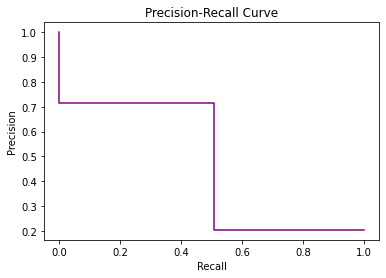

In [ ]:
# посчитаем precision и recall
precision, recall, thresholds = precision_recall_curve(target_valid_ord, model_tree.predict(features_valid_ord))

#создадим кривую precision recall
plt.step(recall, precision, where='post', color='purple')

#добавим подписи
plt.title('Precision-Recall Curve')
plt.ylabel('Precision')
plt.xlabel('Recall')

plt.show() 

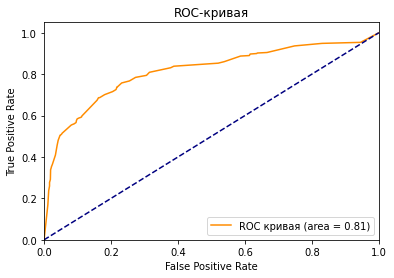

Показатели на тестовой выборке
F1 = 0.5951359084406294
roc_auc = 0.813436822593359


In [ ]:
metrics(target_valid_ord, features_valid_ord, model_tree)

**Итак,** значение метрики F1 = 0.59, roc_auc = 0.81, оба эти показателя выше, чем у логистической регрессии.

## Случайный лес

Построим модель.

In [ ]:
%%time

clf_forest = RandomForestClassifier(random_state=12345) # объявили классификатор

# параметры, которые будут меняться
parametrs = { 'n_estimators': range (40, 71, 10), # число деревьев в лесу
              'max_depth': range (5,15, 2), # глубина дерева
              'min_samples_leaf': range (1,6), # минимальное число образцов в листах
              'min_samples_split': range (4,12,2) } # минимальное число образцов для сплита

# объединим обучающую выборку и валидационную для GridSearchCV
features_gs = pd.concat([features_train_ord, features_valid_ord], ignore_index=True)
target_gs = pd.concat([target_train_ord, target_valid_ord], ignore_index=True)

model_forest = GridSearchCV(clf_forest, parametrs,  cv=5) # cv - генератор перекрестной проверки или итерируемый, по умолчанию
model_forest.fit(features_gs, target_gs)

# выводим лучшие параметры
model_forest.best_params_

CPU times: user 13min 25s, sys: 2.56 s, total: 13min 27s
Wall time: 13min 26s


{'max_depth': 13,
 'min_samples_leaf': 1,
 'min_samples_split': 8,
 'n_estimators': 70}

Построим графики.

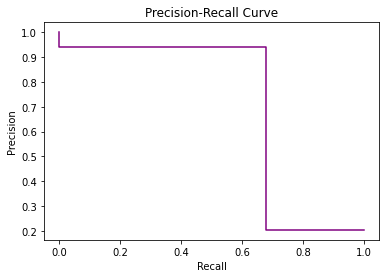

In [ ]:
# посчитаем precision и recall
precision, recall, thresholds = precision_recall_curve(target_valid_ord, model_forest.best_estimator_.predict(features_valid_ord))

#создадим кривую precision recall
plt.step(recall, precision, where='post', color='purple')

#добавим подписи
plt.title('Precision-Recall Curve')
plt.ylabel('Precision')
plt.xlabel('Recall')

plt.show() 

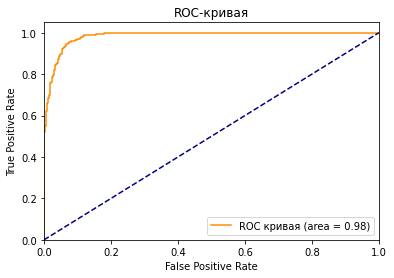

Показатели на тестовой выборке
F1 = 0.7880512091038407
roc_auc = 0.9840994186619372


In [ ]:
metrics(target_valid_ord, features_valid_ord, model_forest.best_estimator_)

**Итак,** в модели случайного леса получили значение F1 = 0.78, roc_auc = 0.98.

## Вывод

Мы подготовили данные для построения моделей. Удалили столбцы, которые не потребуются в построении моделей. Перевели категориальные данные в числовые. Для логистической регрессии использовали метод прямого кодирования. Для случайного леса и дерева решений использовали порядковое кодирование. Также мы масштабировали данные. У нас есть дисбаланс классов. Одного класса почти в 4 раза больше другого. Мы построили три модели без учета дисбаланса и смотрели метрику F1 и ROC кривую. Метрика F1 - это среднее гармоническое между точностью и полнотой(precision и recall), чем она ближе к еденице тем лучше модель. ROC кривая описывает взаимосвязь между чувствительностью модели (TPR - доля истинно положительных примеров) и её специфичностью (описываемой в отношении долей ложноположительных результатов: 1-FPR), сравнивает как чувствительность модели меняется по отношению к ложно положительным долям на разных порогах отсечения. Получили самое низкое качество модели у логистической регрессии(f1 = 0.30, roc_auc = 0.79). Показатель F1 у дерева 0.59, roc_auc = 0.81. Лучшая модель - случайный лес. Его значения F1 = 0.78, roc_auc = 0.98.

# Обучение с учетом дисбаланса

Для того, чтобы сбалансировать наши выборки напишем функции. Функция `downsample` будет уменьшать класс нулей. А функция `upsample` увеличивать класс единиц. 

In [ ]:
def downsample(features, target, fraction):
  features_zeros = features[target == 0]
  features_ones = features[target == 1]
  target_zeros = target[target == 0]
  target_ones = target[target == 1]

  features_downsampled = pd.concat([features_zeros.sample(frac=fraction, random_state=12345)] + [features_ones])
  target_downsampled = pd.concat([target_zeros.sample(frac=fraction, random_state=12345)] + [target_ones])

  features_downsampled, target_downsampled = shuffle(features_downsampled, target_downsampled, random_state=12345)

  return features_downsampled, target_downsampled

In [ ]:
def upsample(features, target, repeat):
    features_zeros = features[target == 0]
    features_ones = features[target == 1]
    target_zeros = target[target == 0]
    target_ones = target[target == 1]
    
    features_upsampled = pd.concat([features_zeros] + [features_ones] * repeat)
    target_upsampled = pd.concat([target_zeros] + [target_ones] * repeat)
    
    features_upsampled, target_upsampled = shuffle(features_upsampled, target_upsampled, random_state=12345)
    
    return features_upsampled, target_upsampled

Применим функции к нашим признакам.

In [ ]:
features_downsample, target_downsample = downsample(features_train_ord, target_train_ord, 0.4)

In [ ]:
target_downsample.value_counts(normalize=True)

0    0.609959
1    0.390041
Name: exited, dtype: float64

In [ ]:
features_upsample, target_upsample = upsample(features_train_ord, target_train_ord, 4)

In [ ]:
target_upsample.value_counts(normalize=True)

1    0.50569
0    0.49431
Name: exited, dtype: float64

In [ ]:
target_train_ord.value_counts()

0    4778
1    1222
Name: exited, dtype: int64

In [ ]:
target_upsample.value_counts()

1    4888
0    4778
Name: exited, dtype: int64

In [ ]:
target_downsample.value_counts()

0    1911
1    1222
Name: exited, dtype: int64

### Логистическая регрессия

Преобразуем признаки для логистической регрессии.

In [ ]:
features_downsample_ohe, target_downsample_ohe = downsample(features_train_ohe, target_train_ohe, 0.4)
features_upsample_ohe, target_upsample_ohe = upsample(features_train_ohe, target_train_ohe, 40)

In [ ]:
clf = LogisticRegression(solver='liblinear', class_weight='balanced', random_state=12345)

def log_model(features, target):
  clf.fit(features, target) # обучим модель

  print(f'F1 = {f1_score(target_valid_ohe, clf.predict(features_valid_ohe))}')
  print(f'roc_auc = {roc_auc_score(target_valid_ohe, clf.predict_proba(features_valid_ohe)[:,1])}')

In [ ]:
print('Изначальные:')
log_model(features_train_ohe, target_train_ohe)
print()
print('Downsample:')
log_model(features_downsample_ohe, target_downsample_ohe)
print()
print('Upsample:')
log_model(features_upsample_ohe, target_upsample_ohe)

Изначальные:
F1 = 0.5298245614035088
roc_auc = 0.7935310744900974

Downsample:
F1 = 0.5313588850174216
roc_auc = 0.793620369001872

Upsample:
F1 = 0.5298245614035088
roc_auc = 0.7934818085525668


После балансировки метрика F1 стала на много лучше(около 0.53), а вот значение roc_auc не изменилось.

### Дерево решений

Напишем функцию и подставим сблансированные классы. 

In [ ]:
def dtc(features, target):
  model_dtc = DecisionTreeClassifier(random_state=12345, max_depth=8)
  model_dtc.fit(features, target)
  print(f'F1 = {f1_score(target_valid_ord, model_dtc.predict(features_valid_ord))}')
  print(f'roc_auc = {roc_auc_score(target_valid_ord, model_dtc.predict_proba(features_valid_ord)[:,1])}')

In [ ]:
print('Изначальные:')
dtc(features_train_ord, target_train_ord)
print()
print('Downsample:')
dtc(features_downsample, target_downsample)
print()
print('Upsample:')
dtc(features_upsample, target_upsample)

Изначальные:
F1 = 0.5951359084406294
roc_auc = 0.813436822593359

Downsample:
F1 = 0.5854166666666666
roc_auc = 0.81821253941275

Upsample:
F1 = 0.5555555555555557
roc_auc = 0.8008917134693073


Метрика не улучшилась, а стала даже хуже после балансировки.

### Случайный лес

In [ ]:
def rfc(features, target):
  model_rfc = RandomForestClassifier(n_estimators=70, max_depth=11, min_samples_split=10, min_samples_leaf=1, random_state=12345) 
  model_rfc.fit(features, target)
  print(f'F1 = {f1_score(target_valid_ord, model_rfc.predict(features_valid_ord))}')
  print(f'roc_auc = {roc_auc_score(target_valid_ord, model_rfc.predict_proba(features_valid_ord)[:,1])}')

In [ ]:
print('Изначальные:')
rfc(features_train_ord, target_train_ord)
print()
print('Downsample:')
rfc(features_downsample, target_downsample)
print()
print('Upsample:')
rfc(features_upsample, target_upsample)

Изначальные:
F1 = 0.5750000000000001
roc_auc = 0.8739761922356881

Downsample:
F1 = 0.6439135381114903
roc_auc = 0.8662214257562321

Upsample:
F1 = 0.6361607142857143
roc_auc = 0.8678548994974875


Получили высокие показатели метрики F1(0.64) после балансировки. Уменьшение выборки сработало лучше. Значение roc_auc в одном диапазоне(0.86).

### Вывод

Для балансировки данных использовали два метода: увеличение класса (`upsamle`) и уменьшение класса (`downsample`). Показатели ROC кривой практически не изменились. А метрика F1 улучшилась для всех моделей. Самая низкая осталась так же у логистической регрессии(0.53). Лучший показатель у модели случайного леса(0.64). 

# Финальное тестирование

Для финального тестирования возьмем модель случайного леса, так как именно эта модель показывала самые высокие показатели. Мы уменьшим классы, так как F1 была выше в методе `downsample`. У нас есть объединенные выборки `train` и `valid` в переменных `features_gs`, `target_gs`.Сбалансируем и обучим модель на новых данных, затем протестируем результаты.

In [ ]:
features_downsample_gs, target_downsample_gs = downsample(features_gs, target_gs, 0.4)

In [ ]:
target_downsample_gs.value_counts(normalize=True)

0    0.609861
1    0.390139
Name: exited, dtype: float64

In [ ]:
%%time

clf_forest_test = RandomForestClassifier(random_state=12345) # объявили классификатор

# параметры, которые будут меняться
parametrs = { 'n_estimators': range (20, 71, 10), # число деревьев в лесу
              'max_depth': range (1,15, 2), # глубина дерева
              'min_samples_leaf': range (1,6), # минимальное число образцов в листах
              'min_samples_split': range (4,12,2) } # минимальное число образцов для сплита

model_forest_test = GridSearchCV(clf_forest, parametrs,  cv=5) # cv - генератор перекрестной проверки или итерируемый, по умолчанию
model_forest_test.fit(features_downsample_gs, target_downsample_gs)

# выводим лучшие параметры
model_forest_test.best_params_

CPU times: user 12min 29s, sys: 2.92 s, total: 12min 32s
Wall time: 12min 35s


{'max_depth': 11,
 'min_samples_leaf': 4,
 'min_samples_split': 10,
 'n_estimators': 40}

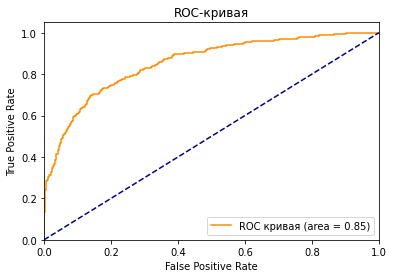

Показатели на тестовой выборке
F1 = 0.6105263157894738
roc_auc = 0.8543782611579223


In [ ]:
metrics(target_test_ord, features_test_ord, model_forest_test.best_estimator_)

# Вывод

Нашей задачей было построить модель, которая бы предсказывала уход клиента из банка. Для определения качества модели мы использовали **F1 меру** и **ROC-кривую**.  
Мы отфильтровали датасет и закодировали категориальные признаки. Для модели логистической регрессии использовали прямое кодирование (`One Hot Encoding`), а для моделей леса и дерева использовали порядковое кодирование (`Ordinal Encoding`). Так как в данных некоторые числовые значения имели разный диапазон значений, мы масштабировали некоторые колонки. В данных наблюдался дисбаланс классов, поэтому использовали разные методы балансировки данных. При этом значения ROC кривой существенно не менялись.  

**Получили результаты:**
* **Логистическая регрессия:** на изначальных данных значение `F1 = 0.32`, `roc_auc = 0.78`. После балансировки максимальное значение `F1` стало 0.53.
* **Дерево решений:** без учета баланса `F1 = 0.59`, `roc_auc = 0.81`. После использования методов балансировки значение меры `F1` уменьшилось до 0.55 - 0.57.
* **Случайный лес:** результат изначальных данных - `F1 = 0.57`, `roc_auc = 0.87`. После метода `downsample` мера `F1 = 0.644`.  

Модель случайного леса показала лучшие результаты, поэтому мы объединили выборки, сбалансировали и снова обучили модель. Проверили модель на тестовых данных, получили: **`F1 = 0.61`, `roc_auc = 0.85`.** Эти показатели говорят о том, что модель довольно хорошо предсказывает потенциальный уход клиента.



